In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
MEASUREMENTS_FILE = 'measurements_v9.csv'
PARAMS_FILE = 'mosfet_params_v9.csv'

# Select a high Vds value where the MOSFET is likely in saturation
# From your data generation script, VDS_STOP was 5.0V [cite: 24]
VDS_SATURATION = 5.0

# --- Load Data ---
try:
    df_meas = pd.read_csv(MEASUREMENTS_FILE)
    print(f"Successfully loaded {MEASUREMENTS_FILE}")
    print(f"Measurement Columns: {df_meas.columns.tolist()}")

    df_params = pd.read_csv(PARAMS_FILE)
    print(f"Successfully loaded {PARAMS_FILE}")
    print(f"Parameter Columns: {df_params.columns.tolist()}") # Check columns like 'KP', 'W', 'L' [cite: 28]

    # Find common MOSFET IDs present in both files
    common_ids = np.intersect1d(df_meas['MOSFET_ID'].unique(), df_params['MOSFET_ID'].unique())
    print(f"\nFound {len(common_ids)} MOSFET IDs common to both files.")
    print(f"Example common IDs: {common_ids[:10]}") # Show first few common IDs

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure both CSV files are in the same directory.")
    df_meas = pd.DataFrame() # Create empty DataFrames to avoid subsequent errors
    df_params = pd.DataFrame()
except Exception as e:
    print(f"An error occurred during file loading: {e}")
    df_meas = pd.DataFrame()
    df_params = pd.DataFrame()

Successfully loaded measurements_v9.csv
Measurement Columns: ['MOSFET_ID', 'meas_index', 'VGS', 'VDS', 'ID']
Successfully loaded mosfet_params_v9.csv
Parameter Columns: ['MOSFET_ID', 'L', 'W', 'KP', 'VTO', 'LAMBDA', 'PHI']

Found 50000 MOSFET IDs common to both files.
Example common IDs: [ 1  2  3  4  5  6  7  8  9 10]


In [13]:
# --- Select MOSFET ---
# Choose a MOSFET ID that exists in both files
# Using ID 120 as an example, like in the reference PDF [cite: 2]
# Make sure this ID is listed in the 'common_ids' from the previous block
selected_mosfet_id = 12120 # <<< CHANGE THIS ID IF NEEDED >>>

df_single_mosfet = pd.DataFrame()
df_sat = pd.DataFrame()
actual_params = None

if not df_meas.empty and not df_params.empty:
    if selected_mosfet_id in common_ids:
        print(f"\nSelecting data for MOSFET_ID: {selected_mosfet_id}")

        # Filter measurement data for the chosen MOSFET
        df_single_mosfet = df_meas[df_meas['MOSFET_ID'] == selected_mosfet_id].copy()
        print(f"Total data points for selected MOSFET: {len(df_single_mosfet)}")

        # Filter for the chosen saturation Vds value
        df_sat = df_single_mosfet[np.isclose(df_single_mosfet['VDS'], VDS_SATURATION)].copy()

        if not df_sat.empty:
            # Calculate sqrt(Id), ensuring Id is non-negative
            df_sat['SQRT_ID'] = np.sqrt(df_sat['ID'].clip(lower=0))
            # Sort by Vgs for plotting
            df_sat = df_sat.sort_values('VGS')
            print(f"Data points at Vds={VDS_SATURATION}V: {len(df_sat)}")
            print("\nSample saturation data (sqrt(Id) added):")
            print(df_sat[['VGS', 'VDS', 'ID', 'SQRT_ID']].head()) # Show relevant columns [cite: 7, 10]

            # Get actual parameters for this MOSFET
            actual_params = df_params[df_params['MOSFET_ID'] == selected_mosfet_id].iloc[0]
            print("\nActual parameters for selected MOSFET:")
            print(actual_params[['L', 'W', 'KP', 'VTO']]) # Display key actual parameters [cite: 28]

        else:
            print(f"Error: No data found for MOSFET_ID {selected_mosfet_id} at Vds={VDS_SATURATION}V.")

    else:
        print(f"Error: MOSFET_ID {selected_mosfet_id} not found in both measurement and parameter files.")
else:
    print("Cannot proceed without measurement and parameter data.")


Selecting data for MOSFET_ID: 12120
Total data points for selected MOSFET: 561
Data points at Vds=5.0V: 11

Sample saturation data (sqrt(Id) added):
         VGS  VDS            ID   SQRT_ID
6798809  0.0  5.0  5.010000e-12  0.000002
6798860  0.5  5.0  5.010000e-12  0.000002
6798911  1.0  5.0  5.010000e-12  0.000002
6798962  1.5  5.0  4.242669e-05  0.006514
6799013  2.0  5.0  1.817298e-04  0.013481

Actual parameters for selected MOSFET:
L      0.000010
W      0.000020
KP     0.000174
VTO    1.032550
Name: 12119, dtype: float64


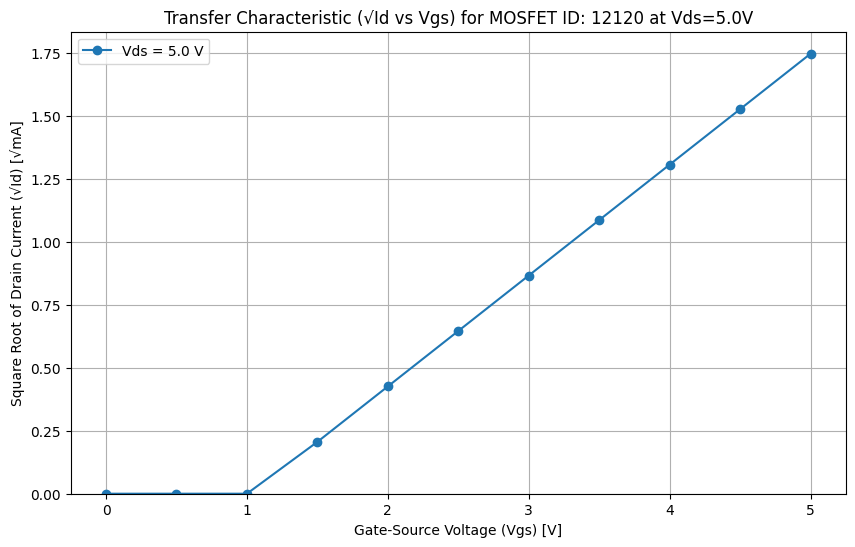

In [14]:
# --- Plot sqrt(Id) vs Vgs ---
if not df_sat.empty:
    plt.figure(figsize=(10, 6))
    # Plot sqrt(Id) in sqrt(mA) for better scale
    plt.plot(df_sat['VGS'], df_sat['SQRT_ID'] * np.sqrt(1000), marker='o', linestyle='-', label=f'Vds = {VDS_SATURATION:.1f} V')

    plt.title(f'Transfer Characteristic (√Id vs Vgs) for MOSFET ID: {selected_mosfet_id} at Vds={VDS_SATURATION:.1f}V') # [cite: 7]
    plt.xlabel('Gate-Source Voltage (Vgs) [V]')
    plt.ylabel('Square Root of Drain Current (√Id) [√mA]') # Adjusted units for plot readability
    plt.grid(True)
    plt.legend()
    plt.ylim(bottom=0)
    plt.show()
else:
    print("Skipping plot because saturation data is not available.")

In [15]:
# --- Threshold Voltage and KP Extrapolation ---
extrapolation_results = {}

# Ensure saturation data and actual parameters were loaded successfully in Block 2
if not df_sat.empty and actual_params is not None:
    # --- Define Linear Region ---
    # Heuristic: Use points clearly in the linear region of the sqrt(Id) vs Vgs plot.
    # Adjust these based on the plot from Block 3 if needed.
    VGS_LINEAR_THRESHOLD_LOW = 1.5
    VGS_LINEAR_THRESHOLD_HIGH = 4.0 # Optional upper limit

    df_linear_region = df_sat[
        (df_sat['VGS'] > VGS_LINEAR_THRESHOLD_LOW) &
        (df_sat['VGS'] <= VGS_LINEAR_THRESHOLD_HIGH) &
        (df_sat['ID'] > 1e-9) # Avoid fitting points near zero Id
    ].copy()

    if len(df_linear_region) >= 2: # Need at least two points for a line
        vgs_linear = df_linear_region['VGS']
        sqrt_id_linear = df_linear_region['SQRT_ID']

        # --- Perform Linear Regression ---
        # Fits sqrt_id = slope * vgs + intercept
        slope, intercept = np.polyfit(vgs_linear, sqrt_id_linear, 1)

        # --- Calculate Vth ---
        vth_extrapolated = -intercept / slope if slope > 1e-9 else np.nan # Avoid division by zero/small slope

        # --- Retrieve Actual Parameters Needed ---
        W = actual_params['W']
        L = actual_params['L']
        lambda_val = actual_params['LAMBDA'] # Get LAMBDA value
        W_div_L = W / L if L != 0 else np.nan

        # --- Calculate KP (Corrected for LAMBDA) ---
        kp_extracted = np.nan # Initialize as NaN
        kp_times_W_div_L = np.nan

        if slope > 1e-9: # Check for valid positive slope
             # Measured Slope^2 = (KP_actual * W / (2*L)) * (1 + LAMBDA * Vds)
             # KP_actual * (W/L) = (2 * Slope^2) / (1 + LAMBDA * Vds)
             lambda_correction_factor = (1 + lambda_val * VDS_SATURATION)

             if lambda_correction_factor > 1e-9: # Avoid division by zero/small number
                  kp_times_W_div_L = (2 * slope**2) / lambda_correction_factor
             # else kp_times_W_div_L remains NaN

             if W_div_L != 0 and not np.isnan(W_div_L) and not np.isnan(kp_times_W_div_L):
                  kp_extracted = kp_times_W_div_L / W_div_L
             # else kp_extracted remains NaN

        print(f"\n--- Linear Extrapolation Results (Vgs {VGS_LINEAR_THRESHOLD_LOW}V - {VGS_LINEAR_THRESHOLD_HIGH}V) ---")
        print(f"Selected {len(df_linear_region)} points for linear fit.")
        print(f"Slope (√A / V): {slope:.4e}")
        print(f"Intercept (√A): {intercept:.4e}")
        print(f"\nExtrapolated Threshold Voltage (Vth): {vth_extrapolated:.4f} V")
        print(f"\nLambda Correction Factor (1 + LAMBDA*Vds): {lambda_correction_factor:.4f}") # Show correction factor
        print(f"Corrected KP * (W/L): {kp_times_W_div_L:.4e} A/V²")
        print(f"Actual W/L ratio: {W_div_L:.4f} (W={W:.2e}, L={L:.2e})")
        print(f"Extrapolated KP: {kp_extracted:.4e} A/V²")

        # Store results for plotting and comparison
        extrapolation_results = {
            'vgs_linear': vgs_linear,
            'sqrt_id_linear': sqrt_id_linear,
            'slope': slope,
            'intercept': intercept,
            'vth': vth_extrapolated,
            'kp': kp_extracted,
            'kp_wl': kp_times_W_div_L, # Corrected value
            'W': W,
            'L': L,
            'W_div_L': W_div_L,
            'lambda_val': lambda_val # Store lambda
        }

    else:
        print(f"\nCould not perform linear fit: Only {len(df_linear_region)} points found in the Vgs range ({VGS_LINEAR_THRESHOLD_LOW}V - {VGS_LINEAR_THRESHOLD_HIGH}V).")
        extrapolation_results = {}
else:
    print("Skipping extrapolation due to missing saturation data or actual parameters.")
    extrapolation_results = {}


--- Linear Extrapolation Results (Vgs 1.5V - 4.0V) ---
Selected 5 points for linear fit.
Slope (√A / V): 1.3934e-02
Intercept (√A): -1.4388e-02

Extrapolated Threshold Voltage (Vth): 1.0325 V

Lambda Correction Factor (1 + LAMBDA*Vds): 1.1000
Corrected KP * (W/L): 3.5303e-04 A/V²
Actual W/L ratio: 2.0309 (W=1.99e-05, L=9.77e-06)
Extrapolated KP: 1.7383e-04 A/V²


In [16]:
# --- Compare Extracted vs Actual ---
if extrapolation_results and actual_params is not None:
    actual_vth = actual_params['VTO'] # Actual Vth is stored as VTO [cite: 28]
    actual_kp = actual_params['KP']  # Actual KP [cite: 28]
    extracted_vth = extrapolation_results.get('vth', np.nan)
    extracted_kp = extrapolation_results.get('kp', np.nan)

    print(f"\n--- Parameter Comparison for MOSFET_ID: {selected_mosfet_id} ---") # [cite: 17]

    # Compare Vth
    print(f"\nThreshold Voltage (Vth):")
    print(f"  Actual (VTO):      {actual_vth:.4f} V") # [cite: 18]
    print(f"  Extrapolated:      {extracted_vth:.4f} V") # [cite: 18]
    if not np.isnan(actual_vth) and not np.isnan(extracted_vth):
        diff_vth = extracted_vth - actual_vth
        err_vth = abs(diff_vth / actual_vth) * 100 if actual_vth != 0 else float('inf')
        print(f"  Difference:        {diff_vth:+.4f} V") # [cite: 18]
        print(f"  Percentage Error:  {err_vth:.2f}%") # [cite: 18]

    # Compare KP
    print(f"\nTransconductance Parameter (KP):")
    print(f"  Actual:            {actual_kp:.4e} A/V²")
    print(f"  Extrapolated:      {extracted_kp:.4e} A/V²")
    if not np.isnan(actual_kp) and not np.isnan(extracted_kp):
        diff_kp = extracted_kp - actual_kp
        err_kp = abs(diff_kp / actual_kp) * 100 if actual_kp != 0 else float('inf')
        print(f"  Difference:        {diff_kp:+.4e} A/V²")
        print(f"  Percentage Error:  {err_kp:.2f}%")

else:
    print("\nSkipping parameter comparison because extrapolation results or actual parameters are not available.")


--- Parameter Comparison for MOSFET_ID: 12120 ---

Threshold Voltage (Vth):
  Actual (VTO):      1.0326 V
  Extrapolated:      1.0325 V
  Difference:        -0.0000 V
  Percentage Error:  0.00%

Transconductance Parameter (KP):
  Actual:            1.7383e-04 A/V²
  Extrapolated:      1.7383e-04 A/V²
  Difference:        -2.7476e-10 A/V²
  Percentage Error:  0.00%


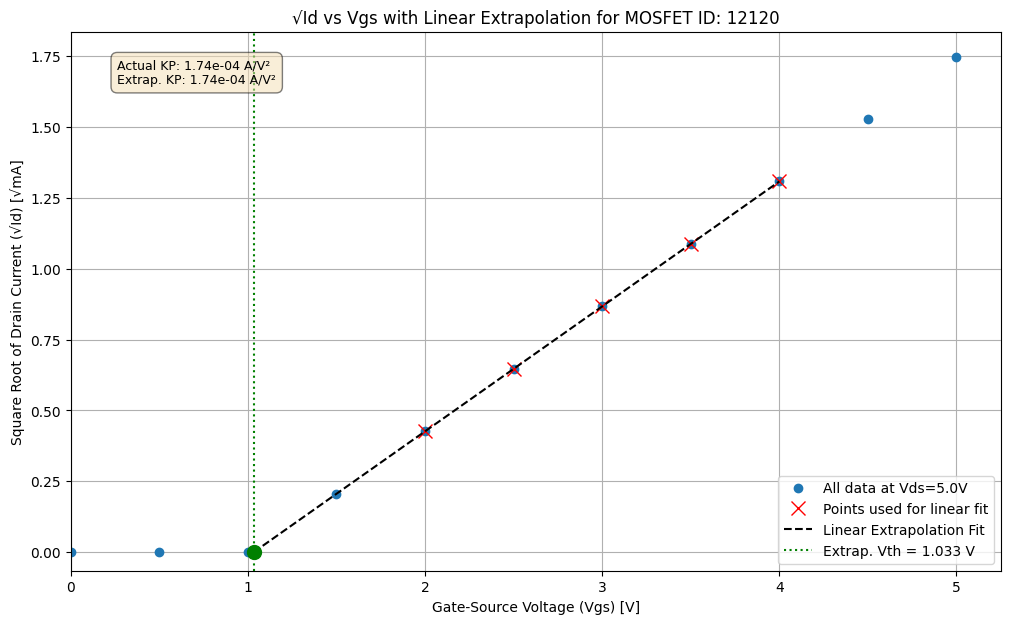

In [17]:
# --- Visualize Extrapolation ---
if not df_sat.empty and extrapolation_results:
    plt.figure(figsize=(12, 7))

    # Plot all sqrt(Id) points
    plt.plot(df_sat['VGS'], df_sat['SQRT_ID'] * np.sqrt(1000), marker='o', linestyle=' ', label=f'All data at Vds={VDS_SATURATION:.1f}V') # [cite: 20]

    # Highlight points used for linear fit
    plt.plot(extrapolation_results['vgs_linear'],
             extrapolation_results['sqrt_id_linear'] * np.sqrt(1000),
             marker='x', markersize=10, linestyle='none', color='red',
             label='Points used for linear fit') # [cite: 20]

    # Plot the fitted line
    # Generate points for the line spanning the fitted region and extending to Vth
    vgs_fit_line = np.linspace(extrapolation_results['vth'], extrapolation_results['vgs_linear'].max(), 10)
    sqrt_id_fit_line = extrapolation_results['slope'] * vgs_fit_line + extrapolation_results['intercept']
    plt.plot(vgs_fit_line, sqrt_id_fit_line * np.sqrt(1000), linestyle='--', color='black', label='Linear Extrapolation Fit') # [cite: 20]

    # Mark the extrapolated Vth
    vth_val = extrapolation_results['vth']
    plt.axvline(vth_val, color='green', linestyle=':', label=f'Extrap. Vth = {vth_val:.3f} V') # [cite: 21]
    plt.scatter([vth_val], [0], color='green', s=100, zorder=5) # Mark point on axis [cite: 21]

    plt.title(f'√Id vs Vgs with Linear Extrapolation for MOSFET ID: {selected_mosfet_id}')
    plt.xlabel('Gate-Source Voltage (Vgs) [V]')
    plt.ylabel('Square Root of Drain Current (√Id) [√mA]') # Unit adjusted

    # Add text annotation for KP comparison (optional)
    if 'kp' in extrapolation_results and actual_params is not None:
        kp_text = (f"Actual KP: {actual_params['KP']:.2e} A/V²\n"
                   f"Extrap. KP: {extrapolation_results['kp']:.2e} A/V²")
        # Position the text box - adjust x, y as needed
        plt.text(0.05, 0.95, kp_text, transform=plt.gca().transAxes, fontsize=9,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    plt.legend(loc='lower right')
    plt.grid(True)
    # Adjust limits to show intercept clearly [cite: 21]
    plt.ylim(bottom=-0.05 * (extrapolation_results['sqrt_id_linear'] * np.sqrt(1000)).max())
    plt.xlim(left=0)
    plt.show()

elif df_sat.empty:
    print("Cannot visualize extrapolation due to missing saturation data.")
else: # extrapolation_results is empty
    print("Cannot visualize extrapolation because linear fit failed or was not performed.")